# Advanced ML: Домашнее задание 3
## Спортивное "Что? Где? Когда?"

Николай Горев

Группа MADE-DS-22

In [1]:
import numpy as np
import json, pickle
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import lil_matrix, vstack
from sklearn.linear_model import LogisticRegression
import math
from scipy.stats import spearmanr, kendalltau
from tabulate import tabulate

In [2]:
tournaments = pickle.load(open('chgk/tournaments.pkl', 'rb'))
results = pickle.load(open('chgk/results.pkl', 'rb'))
players = pickle.load(open('chgk/players.pkl', 'rb'))

**1.** Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
- взять в тренировочный набор турниры с dateStart из 2019 года; 
- в тестовый — турниры с dateStart из 2020 года.

In [3]:
import dateutil.parser

def containsMask(tournamentResults):
    for teamResult in tournamentResults:
        if ('mask' in teamResult and 
            teamResult['mask'] is not None):
            return True
    return False

def containsTeamMembers(tournamentResults):
    for teamResult in tournamentResults:
        if len(teamResult['teamMembers']) > 0:
            return True
    return False
    
train_tournaments_ids = []
test_tournaments_ids = []
for tournament_id, v in tournaments.items():
    year = dateutil.parser.parse(v['dateStart']).year
    if (containsMask(results[tournament_id]) and 
        containsTeamMembers(results[tournament_id])):
        if year == 2019:
            train_tournaments_ids.append(tournament_id)
        if year == 2020:
            test_tournaments_ids.append(tournament_id)

In [4]:
len(train_tournaments_ids), len(test_tournaments_ids)

(675, 173)

**2.**	Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

Будем считать, что $i$-й игрок обладает силой $s_i$, а $j$-й вопрос имеет сложность $q_j$, При этом вероятность ответа $i$-го игрока на $j$-й вопрос равна $p_{ij}=\sigma(s_i-q_j)$.

В baseline-модели мы предполагаем, что повопросные результаты команды относятся к каждому из её игроков, т.е. мы считаем известными результаты ответа $i$-го игрока на $j$-й вопрос.

Таким образом, мы получаем модель логистической регрессии с разреженной матрицей признаков. Количество столбцов матрицы признаков равно сумме общего количества игроков и общего числа вопросов. В каждой строке этой матрицы, соответствующей ответу $i$-го игрока на $j$-й вопрос стоят нули, единица и минус единица в столбцах, соответствующих $i$-му игроку и $j$-му вопросу.

In [5]:
# ids игроков в тренировочном наборе
players_ids = set()

# рейтинг игроков
players_ratings = {}

# Общее число вопросов в тренировочном наборе
total_questions = 0

# список данных по всем турнирам тренировочного набора
train_data = []

for tournament_id in train_tournaments_ids:
    tournament_data = {}
    tournament_data['id'] = tournament_id
    
    # n_questions - число вопросов в турнире
    # - максимальное количество по всем командам в турнире
    n_questions = 0
    for team in results[tournament_id]:
        if ('mask' in team and team['mask'] is not None and
            n_questions < len(team['mask'])):
            n_questions = len(team['mask'])
    tournament_data['n_questions'] = n_questions
    total_questions += n_questions
    tournament_data['teams'] = []

    for team in results[tournament_id]:
        # отбираем только те команды, для которых есть данные по всем вопросам
        if ('mask' in team and team['mask'] is not None and
            n_questions == len(team['mask'])):
            # team_data - словарь данных по отдельной команде турнира
            team_data = {}
            # общее количество правильных ответов команды в турнире
            team_data['questionsTotal'] = team['questionsTotal']
            # результаты ответов на вопросы
            team_data['answers'] = [int(answer == '1') for answer in team['mask']]
            # id игроков команды
            team_data['players_ids'] = [p['player']['id'] for p in team['teamMembers']]
            # количество игроков в команде
            team_data['n_players'] = len(team_data['players_ids'])
            if team_data['n_players'] > 0:
                tournament_data['teams'].append(team_data)
            
            for team_member in team['teamMembers']:
                player_id = team_member['player']['id']
                player_rating = team_member['rating']
                players_ids.add(player_id)
                players_ratings[player_id] = player_rating

    train_data.append(tournament_data)
    
players_ids = sorted(list(players_ids))

# номер в списке по id игрока
player_id2number = {id : number for number, id in enumerate(players_ids)}

# общее число игроков
total_players = len(players_ids)    

In [6]:
# число столбцов в матрице признаков равно числу игроков 
# плюс общее количество вопросов
X_cols = total_players + total_questions

In [7]:
# Подсчитаем количество строк в матрице признаков:
# суммируем по каждому турниру и каждой команде произведение
# числа игроков в команде на количество вопросов
X_rows = 0
for tournament_data in train_data:
    for team_data in tournament_data['teams']:
        X_rows += team_data['n_players'] * tournament_data['n_questions']

In [8]:
# формируем матрицу признаков и вектор правых частей логистической регрессии
X = lil_matrix((X_rows, X_cols), dtype=np.int8)
y = np.zeros(X_rows)

questions_idx_shift = total_players
n_row = 0
for tournament_data in train_data:
    for team_data in tournament_data['teams']:
        for i_question in range(tournament_data['n_questions']):
            true_y = team_data['answers'][i_question]
            question_idx = questions_idx_shift + i_question
            for player_id in team_data['players_ids']:
                i_player = player_id2number[player_id]
                X[n_row, i_player] = 1
                X[n_row, question_idx] = -1
                y[n_row] = true_y
                n_row += 1
    questions_idx_shift += tournament_data['n_questions']

In [9]:
model = LogisticRegression(solver='saga', C=1)
model.fit(X, y);

In [10]:
# результаты моделирования - сила игроков и сложность вопросов
def getResults(model):
    return model.coef_[0][:total_players], model.coef_[0][total_players:] - model.intercept_

strength, complexity = getResults(model)

Посмотрим на распределения силы игроков и сложности вопросов.

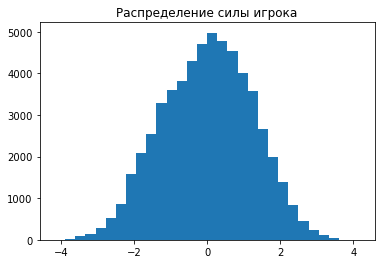

In [11]:
plt.hist(strength, bins=30);
plt.title('Распределение силы игрока');

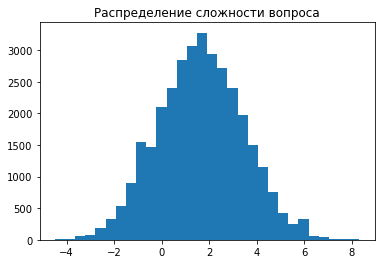

In [12]:
plt.title('Распределение сложности вопроса');
plt.hist(complexity, bins=30);

По виду, распределения похожи на нормальные. Будем считать их нормальными. Это нам понадобится в следующем пункте.

**3.** Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

Если известна сила $i$-го игрока $s_i$ и сложность $j$-го вопроса $q_j$, то вероятность правильного ответа вычисляется с помощью сигмоидальной функции $p_{ij} = \sigma(s_i - q_j)$.

Если мы знаем силу $i$-го игрока $s_i$, но не знаем сложность вопроса, то вероятность правильного ответа оценим математическим ожиданием по распределению сложности вопросов: $p_i = \mathbb{E}_q[p_{ij}] = \int \sigma(s_i - q) p(q) dq$.

Если сложность вопроса распределена нормально со средним $\mu_q$ и дисперсией $\sigma^2_q$, то, используя при вычислении интеграла приближенную замену сигмоидальной функции пробитом, можно получить $$p_i \approx \sigma\left( \frac{s_i - \mu_q}{\sqrt{1 + \frac{\pi}{8}\sigma^2_q}}\right)$$.

Но что, если мы не знаем силу игрока? Тогда нам придется также усреднить по распределению силы игрока, которое будем считать нормальным с параметрами $\mu_s$ и $\sigma^2_s$: $$p_{u} \approx \sigma\left( \frac{\mu_s - \mu_q}{\sqrt{1 + \frac{\pi}{8}(\sigma^2_s +\sigma^2_q)}}\right)$$

Будем считать, что команда дает правильный ответ, если хотя бы один игрок команды знает правильный ответ. Если мы знаем вероятность правильного ответа $p_i$ для каждого игрока команды, то вероятность ответа для команды равна $p_c = 1 - \prod (1 - p_i)$.

Будем предсказывать ранжирование команд по предсказанным значениям вероятности ответа для команды $p_c$.

In [13]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def testPerformance(strength, complexity):
    mu_q = complexity.mean()
    sigma2_q = complexity.var()
    mu_s = strength.mean()
    sigma2_s = strength.var()

    # вероятность правильного ответа на неизвестный вопрос для всех игроков
    p_player = {}
    for player_id in players_ids:
        si = strength[player_id2number[player_id]]
        p_player[player_id] = sigmoid((si - mu_q) / math.sqrt(1 + math.pi / 8 * sigma2_q))

    # вероятность правильного ответа для игрока, которого не было в обучающей выборке
    default_p_player = sigmoid((mu_s - mu_q) / math.sqrt(1 + math.pi / 8 * (sigma2_s + sigma2_q)))

    spearman_cor = []
    kendall_cor = []
    for tournament_id in test_tournaments_ids:
        res = results[tournament_id]
        if len(res) <= 1:
            continue
        true_performance = []
        predicted_strength = []
        for team in res:
            true_performance.append(team['questionsTotal'])
            p_ids = [p['player']['id'] for p in team['teamMembers']]
            p_i = np.asarray([p_player.get(idx, default_p_player) for idx in p_ids])
            predicted_strength.append(1 - (1 - p_i).prod())
        spearman_cor.append(spearmanr(true_performance, predicted_strength).correlation)
        kendall_cor.append(kendalltau(true_performance, predicted_strength).correlation)
    return np.mean(spearman_cor), np.mean(kendall_cor)

spearman_cor, kendall_cor = testPerformance(strength, complexity)

print('Корреляция Спирмена = ', spearman_cor)
print('Корреляция Кендалла = ', kendall_cor)


Корреляция Спирмена =  0.7424294640707046
Корреляция Кендалла =  0.5857304851175984


**4.** Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

В baseline-модели мы предполагали, что известный результат ответа на вопрос команды отностится ко всем игрокам команды. Однако на самом деле это не так. Правильный ответ могут знать не все игроки команды. Введем скрытые переменные $z_{ij} = 1$, если $i$-й игрок знает правильный ответ на $j$-й вопрос. Будем считать, что команда дает правильный ответ, если хотя бы один из игроков команды знает правильный ответ, а если никто из игроков не знает правильного ответа, то команда не дает правильного ответа.

Обозначим $\theta_n$ - параметры модели (силу игроков и сложность модели) с предыдущей итерации ЕМ алгоритма; $y$ - результат ответа на вопрос команды. 

Так как для правильного ответа команды необходимо, чтобы хотя бы один игрок знал правильный ответ, $p(y|\theta_n)=1-\prod_i(1-p(z_{ij}|\theta_n)$.

Используя теорему Байеса, получаем $$p(z_{ij}|y,\theta_n)=\frac{p(y|z_{ij}, \theta_n)\cdot p(z_{ij}|\theta_n)}{p(y|\theta_n)}=\begin{cases} 
\frac{p(z_{ij}|\theta_n)}{1-\prod_i(1-p(z_{ij}|\theta_n)}, &\text{если $y = 1$;}\\
0, &\text{в противном случае}
\end{cases}$$.

Вычисляя математическое ожидание Е-шага, получаем: $$Q(\theta, \theta_n)=\mathbb{E}[\log p(y, z|\theta)|y,\theta_n] = \sum p(z|y,\theta_n) \log p(y, z|\theta) + (1 - p(z|y, \theta_n)) \log(1 - p(y, z|\theta))$$

Получаем выражение, аналогичное кросс-энтропии, минимизируемой при обучении логистической регрессии, в котором вместо изветсных бинарных ответов входят дробные вероятности $p(z|y, \theta_n)$.

Модель логистической регрессии из библиотеки `sklearn` требует бинарных (`0` и `1`) ответов. Чтобы использовать её для М-шага нашего алгоритма для каждой строчки исходной матрицы признаков поступим так:
- создадим две идентичных копии строки матрицы признаков
- создадим два значения правых частей - `0` и `1`, 
- и два значения `sample_weight` равные $p(z_{ij}|y, \theta_n)$ и $1 - p(z_{ij}|y, \theta_n)$ для скрытой переменной $z_{ij}$, соответствующей данной строке матрицы признаков.

Затем обучим полученную логистическую модель стандартным способом - это будет М-шаг алгоритма.

In [14]:
X2 = vstack([X, X], format='lil', dtype=np.int8)
y2 = np.array([1] * X.shape[0] + [0] * X.shape[0])

In [15]:
def updateWeights(model):
    predictions = model.predict_proba(X)
    
    sample_weight = np.zeros(X_rows * 2)

    n_row = 0
    for tournament_data in train_data:
        for team_data in tournament_data['teams']:
            n_team_players = team_data['n_players']
            for i_question in range(tournament_data['n_questions']):
                true_y = team_data['answers'][i_question]
                if true_y == 0:
                    sample_weight[n_row : n_row + n_team_players] = 0
                    sample_weight[X_rows + n_row : X_rows + n_row + n_team_players] = 1
                else:
                    p_i = predictions[n_row : n_row + n_team_players, 1]
                    p_i = p_i / (1 - (1 - p_i).prod())
                    p_i = np.clip(p_i, 0, 1)
                    sample_weight[n_row : n_row + n_team_players] = p_i
                    sample_weight[X_rows + n_row : X_rows + n_row + n_team_players] = 1 - p_i
                n_row += n_team_players

    return sample_weight

In [16]:
# Обучаем ЕМ алгоритм
EM_STEPS = 20
best_spearman_cor = 0
for step in range(EM_STEPS):
    sample_weight = updateWeights(model)
    model.fit(X2, y2, sample_weight=sample_weight)
    strength, complexity = getResults(model)
    spearman_cor, kendall_cor = testPerformance(strength, complexity)
    print(f'Шаг ЕМ алгоритма: {step + 1}; целевые метрики на тестовом множестве:')
    print(f'Корреляции: Спирмена = {spearman_cor}, Кендалла = {kendall_cor}')
    if spearman_cor > best_spearman_cor:
        spearman_cor = best_spearman_cor
        best_strength = strength
        best_complexity = complexity

Шаг ЕМ алгоритма: 1; целевые метрики на тестовом множестве:
Корреляции: Спирмена = 0.7515329328631435, Кендалла = 0.5941087684294235
Шаг ЕМ алгоритма: 2; целевые метрики на тестовом множестве:
Корреляции: Спирмена = 0.7520671635192997, Кендалла = 0.5946110664126237
Шаг ЕМ алгоритма: 3; целевые метрики на тестовом множестве:
Корреляции: Спирмена = 0.7539199159579044, Кендалла = 0.5965326920584354
Шаг ЕМ алгоритма: 4; целевые метрики на тестовом множестве:
Корреляции: Спирмена = 0.7547841027354937, Кендалла = 0.5975961136074738
Шаг ЕМ алгоритма: 5; целевые метрики на тестовом множестве:
Корреляции: Спирмена = 0.7548115525583241, Кендалла = 0.5979219843989646
Шаг ЕМ алгоритма: 6; целевые метрики на тестовом множестве:
Корреляции: Спирмена = 0.7564787031597451, Кендалла = 0.599863431449208
Шаг ЕМ алгоритма: 7; целевые метрики на тестовом множестве:
Корреляции: Спирмена = 0.7572971494021951, Кендалла = 0.6008134631947335
Шаг ЕМ алгоритма: 8; целевые метрики на тестовом множестве:
Корреляции

В исходных данных среди прочего присутствуют рейтинги игроков. Интересно сравнить их с вычисленной силой игроков.

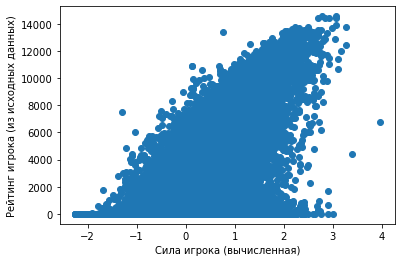

In [17]:
true_ratings = [players_ratings[players_ids[i]] for i in range(total_players)]

plt.scatter(best_strength, true_ratings)
plt.xlabel('Сила игрока (вычисленная)')
plt.ylabel('Рейтинг игрока (из исходных данных)')
plt.show();

Можно считать, что между этими величинами имеется некоторая положительная взаимосвязь.

**5.**	А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? 

In [18]:
tournaments_complexity = []
questions_shift = 0
for tournament_data in train_data:
    tournament_id = tournament_data['id']
    n_questions = tournament_data['n_questions']
    tournaments_complexity.append((tournaments[tournament_id]['name'], 
        np.median(best_complexity[questions_shift : questions_shift + n_questions])))
    questions_shift += n_questions
    
tournaments_complexity.sort(key=lambda x : x[1], reverse=True)

In [19]:
headers=['Название турнира', 'Средний уровень сложности вопросов']
print(tabulate(tournaments_complexity, headers))

Название турнира                                               Средний уровень сложности вопросов
-----------------------------------------------------------  ------------------------------------
Чемпионат Санкт-Петербурга. Первая лига                                                   5.89638
Первенство правого полушария                                                              4.94614
Угрюмый Ёрш                                                                               4.932
Синхрон высшей лиги Москвы                                                                4.87806
Кубок городов                                                                             4.66815
Воображаемый музей                                                                        4.59626
Тихий Донец: омут первый                                                                  4.56611
Записки охотника                                                                          4.55429
Чемпионат Мира. Этап 2

Мы видим, что полученный рейтинг-лист турниров соответствует интуиции. На первом месте чемпионат Санкт-Петербурга, первая лига. Турниры чемпионата мира находятся вверху списка, а школьные турниры - ближе к концу.